In [98]:

import base64
import requests
from openai import OpenAI
import os
import re
import shutil
import time
class GPTCaller:
    def __init__(self):
        self.client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        directory = "./tmp/temp"
        self.messages=[]
        self.response_format={}
        # Remove the directory if it exists
        if os.path.exists(directory):
            shutil.rmtree(directory)

        # Create a new empty directory
        os.makedirs(directory, exist_ok=True)

    def encode_image(self,image):
        if type(image) == str:
            with open(image, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        else:
            directory="./tmp/temp"
            extension = ".png"

            files = os.listdir(directory)
            
            # Filter files based on the pattern 'temp<number>.png'
            pattern = re.compile(rf"^(\d+){extension}$")
            indices = [int(pattern.match(f).group(1)) for f in files if pattern.match(f)]
            
            # Determine the next index
            if indices:
                next_index = max(indices) + 1
            else:
                next_index = 0
            
            # Construct the new file name
            new_file_name = f"{next_index}{extension}"
            new_file_path = os.path.join(directory, new_file_name)
            
            # Save the image
            image.save(new_file_path)
            
            # Return the encoded image or the path, as needed
            return self.encode_image(new_file_path)

    def create_prompt(self, user_prompt_list=[],system_prompt_list=[],response_format=None):
        messages = []
        content=[]
        for item in system_prompt_list:
            content.append({
                    "type": "text",
                    "text": item
                })
            

        messages.append({
            "role": "system",
            "content": content
        })
        
        content=[]

        for item in user_prompt_list:

            if type(item) == str:
                content.append({
                    "type": "text",
                    "text": item
                })
            
            else:
                base64_image=self.encode_image(item)

                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                        "detail": "high"

                    }
                })


        messages.append({
            "role": "user",
            "content": content
        })
        if response_format is not None:
            self.response_format=response_format
        self.messages=messages

    def call(self,temperature=0.5,model="chatgpt-4o-latest"):
        start_time = time.time()
        if model == "chatgpt-4o-latest":
            completion = self.client.chat.completions.create(
            model=model,
            messages=self.messages,temperature=temperature,
            )
        else:
            completion = self.client.chat.completions.create(
            model=model,
            messages=self.messages,temperature=temperature,
            response_format=self.response_format
            
            )

        #print(completion.choices[0].message)
        print(f"GPT call time taken: {time.time()-start_time:.2f} seconds")
        return completion.choices[0].message.content


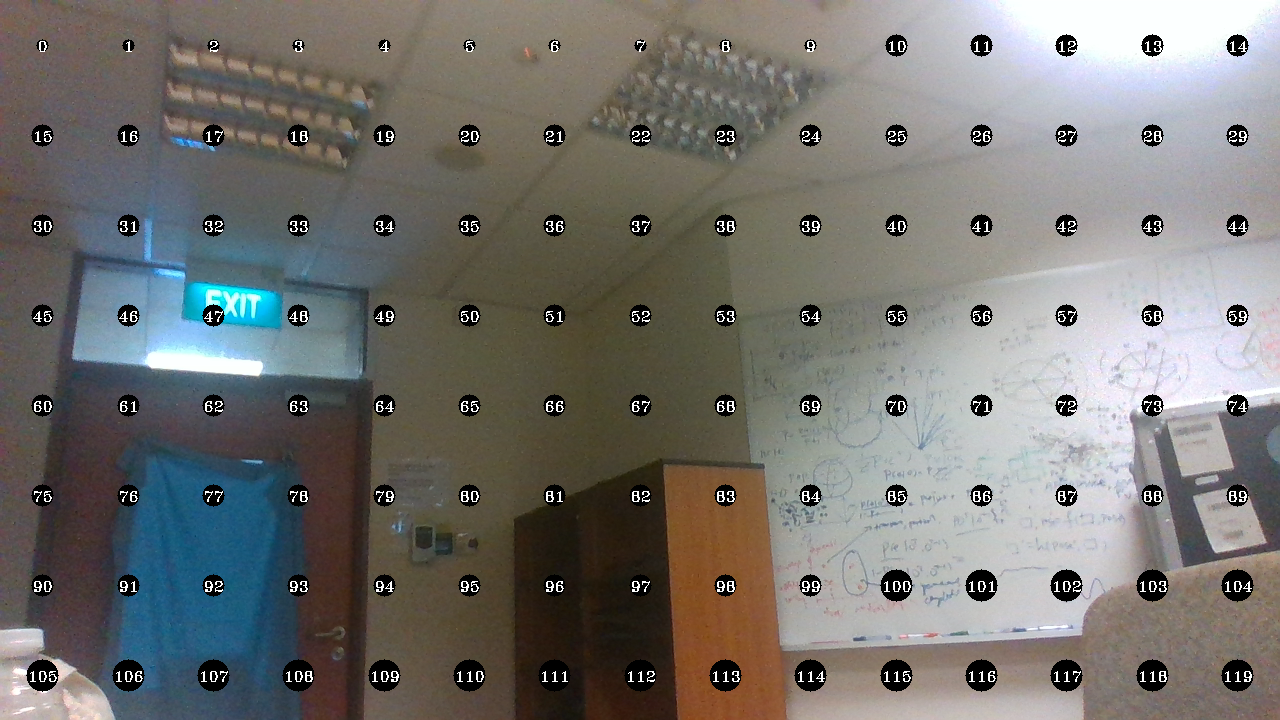

In [99]:
import cv2
import numpy as np
from PIL import Image

def point_grid_label(image, points_num=32):
    is_pil = not isinstance(image, np.ndarray)
    point_labeled_image_list = []
    points_coord_list = []
        
    if is_pil:
        image = np.asarray(image)
    height, width, _ = image.shape
    
    # Determine the number of rows and columns for the grid based on the aspect ratio
    aspect_ratio = width / height
    grid_cols = int((points_num * aspect_ratio) ** 0.5)
    grid_rows = int(points_num / grid_cols)
    
    # Load a larger font
    font_scale = 0.5 # Adjust this value as needed
    font_thickness = 1  # Adjust this value as needed
    font = cv2.FONT_HERSHEY_TRIPLEX
            
    # Calculate coordinates for grid points
    for i in range(grid_rows):
        for j in range(grid_cols):
            x = int((j + 0.5) * width / grid_cols)
            y = int((i + 0.5) * height / grid_rows)
            points_coord_list.append((x, y))
            text = str(i * grid_cols + j)
            (text_width, text_height), baseline = cv2.getTextSize(
                        text,
                        font,
                        font_scale,
                        2  # thickness
                    )

            # Draw a solid black circle
            radius = max(text_width, text_height) // 2  # Add some padding
            cv2.circle(image, (x, y), radius, (0, 0, 0), -1)
                    
            # Calculate text size and position to center it
            text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
            text_x = x - text_size[0] // 2
            text_y = y + text_size[1] // 2
                    
            # Draw the number in white
            cv2.putText(image, text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
    
    if is_pil:
        image = Image.fromarray(image)
    point_labeled_image_list.append(image)
        
    return point_labeled_image_list, points_coord_list

# Example usage
image = Image.open('/root/catkin_ws/src/guide_dog/src/log/20240904_090407/raw_image/image_0/image.png')
result_image, points = point_grid_label(image,128)
result_image[0].show()

In [100]:
import cv2
import numpy as np
from PIL import Image

def draw_vertical_lines_with_numbers(image, sections=8):
    is_pil = not isinstance(image, np.ndarray)
    if is_pil:
        image = np.asarray(image)
    
    # Downsample the image to 720p resolution
    image = cv2.resize(image, (1280, 720))
    
    height, width, _ = image.shape
    
    # Calculate the width of each section
    section_width = width // sections
    
    # Load a larger font
    font_scale = 5.0  # Adjust this value as needed
    font_thickness = 3  # Adjust this value as needed
    font = cv2.FONT_HERSHEY_TRIPLEX
    
    for i in range(sections):
        x = i * section_width
        
        # Draw thicker red vertical line
        cv2.line(image, (x, 0), (x, height), (0, 0, 255), 4)
        
        # Calculate the center of the section for the number
        center_x = x + section_width // 2
        
        # Prepare the number text
        text = str(i + 1)
        (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
        
        # Draw black background for the number at the top
        top_rect_start = (center_x - text_width // 2 - 10, 10)
        top_rect_end = (center_x + text_width // 2 + 10, text_height + 20)
        cv2.rectangle(image, top_rect_start, top_rect_end, (0, 0, 0), -1)
        
        # Draw the number in white at the top
        top_text_x = center_x - text_width // 2
        top_text_y = text_height + 10
        cv2.putText(image, text, (top_text_x, top_text_y), font, font_scale, (255, 255, 255), font_thickness)
        
        # Draw black background for the number at the bottom
        bottom_rect_start = (center_x - text_width // 2 - 10, height - text_height - 20)
        bottom_rect_end = (center_x + text_width // 2 + 10, height - 10)
        cv2.rectangle(image, bottom_rect_start, bottom_rect_end, (0, 0, 0), -1)
        
        # Draw the number in white at the bottom
        bottom_text_x = center_x - text_width // 2
        bottom_text_y = height - 10
        cv2.putText(image, text, (bottom_text_x, bottom_text_y), font, font_scale, (255, 255, 255), font_thickness)
    
    if is_pil:
        image = Image.fromarray(image)
    
    return image



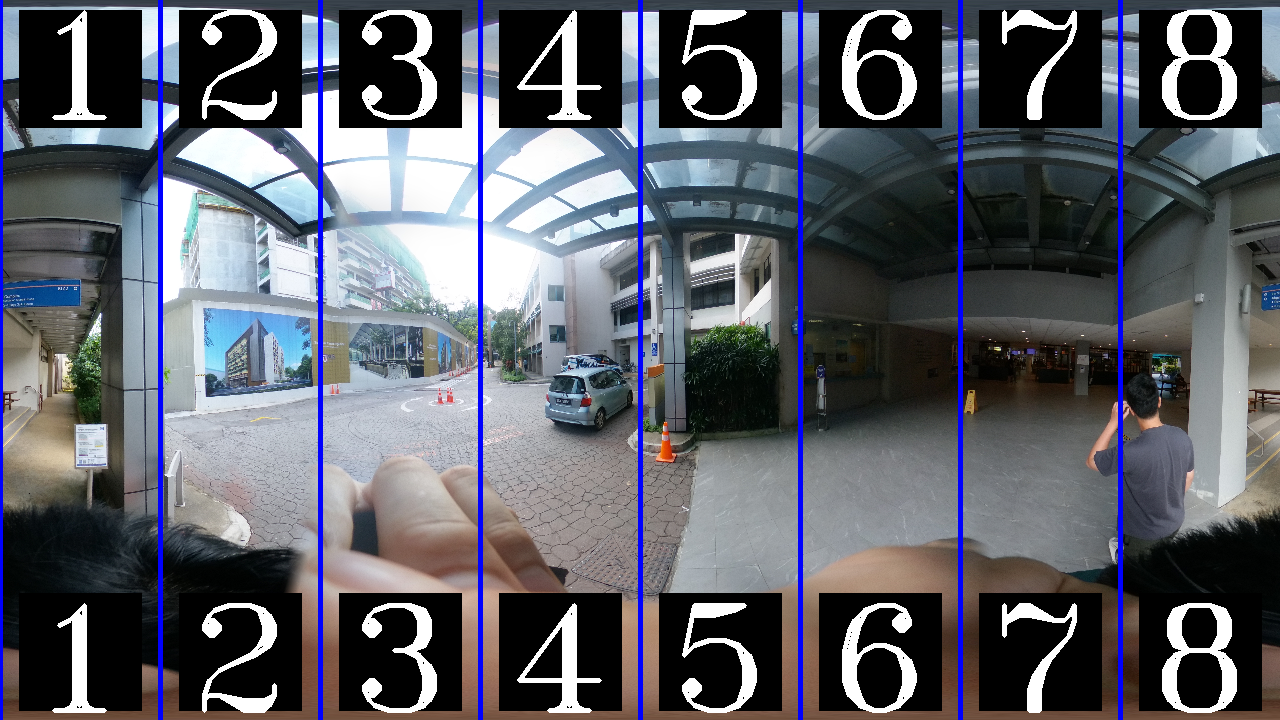

In [118]:

file_path='/root/catkin_ws/src/guide_dog/src/images/R0010034.JPG'
image = Image.open(file_path)

labeled_image=draw_vertical_lines_with_numbers(image)
labeled_image.show()
labeled_image.save(file_path.replace('.JPG','_labeled.JPG'))


In [120]:
from dotenv import load_dotenv
import os
import json
from io import BytesIO

# Load environment variables from .env file
load_dotenv()

caller = GPTCaller()
with open('./prompts/visual_selector/vertical_section', 'r') as file:
    prompt_json = json.loads(file.read())
system_prompt=prompt_json["system_prompt"]
response_format=prompt_json["response_format"]
user_prompt="i need to go to the most likely direction to a washroom"

caller.create_prompt([user_prompt,labeled_image],system_prompt_list=[system_prompt],response_format=response_format)
response=caller.call(model="gpt-4o-2024-08-06")
print(f"gpt response is {response}")

GPT call time taken: 7.07 seconds
gpt response is {"reasoning_steps":["1: There is a blue sign on the left side of the image, which might indicate directions, possibly to a washroom. Confidence: 7.","2: This section shows an outdoor area with a building in the background, no signs or indicators of a washroom. Confidence: 2.","3: Similar to section 2, it shows an outdoor area with no clear signs of a washroom. Confidence: 2.","4: Shows a parking area with a car, no signs or indicators of a washroom. Confidence: 3.","5: This section shows a building entrance, but there are no visible signs indicating a washroom. Confidence: 4.","6: Shows an indoor area, but no visible signs or indicators of a washroom. Confidence: 3.","7: Contains a wet floor sign but no visible washroom signs. Confidence: 5.","8: There is a blue sign on the right side of the image, which might indicate directions, possibly to a washroom. Confidence: 6."],"final_decision":"1"}
